Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [3]:
import sys
sys.path.append("../..")
from src import convex_return_mapping as crm # there is a conflict in the order of imported modules

import meshio
import ufl
from dolfinx import fem, io, common
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

from src import fenicsx_support as fs
from src import plasticity_framework as pf

In [5]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("../mesh/thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [6]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [7]:
# elastic parameters
sig0_dim = 70e3 #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim #[-]
nu = 0.3 #[-]
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))

sig0 = 250 / sig0_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [8]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
WTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(4, 4), quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)
WT = fem.FunctionSpace(mesh, WTe)

In [9]:
sig = fem.Function(W)
sig_old = fem.Function(W)
p = fem.Function(W0, name="Cumulative_plastic_strain")
p_old = fem.Function(W0, name="Cumulative_plastic_strain")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
C_tang = fem.Function(WT)

deps = fem.Function(W, name="deps")

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

In [10]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [11]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

SQRT2 = np.sqrt(2.)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def eps_vec(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_vector([e[0, 0], e[1, 1], 0, SQRT2 * e[0, 1]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3] / SQRT2, 0],
                          [X[3] / SQRT2, X[1], 0],
                          [0, 0, X[2]]])       

In [12]:
vonMises = crm.vonMises(sig0, H)
alpha = 1.
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

N = patch_size = 3 # or batch, or group ?
N_patches = int(n_quadrature_points/patch_size)
residue_size = n_quadrature_points % patch_size

return_mapping = crm.ReturnMapping(material, patch_size)

p_values = p.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
p_old_values = p_old.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
deps_values = deps.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_values = sig.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_old_values = sig_old.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
C_tang_values = C_tang.x.array[:4*4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4, 4))

if residue_size != 0:
    return_mapping_residue = crm.ReturnMapping(material, residue_size)
    
    p_values_residue = p.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    p_old_values_residue = p_old.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    deps_values_residue = deps.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_values_residue = sig.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_old_values_residue = sig_old.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    C_tang_values_residue = C_tang.x.array[4*4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4, 4))

In [13]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps_vec(v), ufl.dot(C_tang, eps_vec(u_)))*dx 
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

my_problem = pf.LinearProblem(a_Newton, res, Du, bcs)

In [14]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

In [15]:
def error_norm1(uh, u):
    return np.sum(np.abs(u - uh)) / np.sum(np.abs(u))

def error_norm2(uh, u):
    return np.sqrt(np.dot(u - uh, u - uh)) / np.sqrt(np.dot(u, u))

C_fake = fem.Function(WT)
for i in range(n_quadrature_points):
    C_fake.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

In [16]:
Nitermax, tol = 200, 1e-7  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
load_steps = load_steps
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
p_old.vector.set(0.0)
u.vector.set(0.0)
du.vector.set(0.0)

n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

my_problem.assemble()
# T.vector.norm - bug, where T is a tensor???

logging_parts = ['convex_solving', 'convex_solving_cvxpy', 'differentiation', 'return_mapping', 'differentiation_total', 'convex_solving_total']
main_logging_parts = ['convex_solving', 'convex_solving_cvxpy', 'differentiation']

time_logging = {}
time_logging_local = {}
for part in logging_parts: 
    time_logging[part] = np.zeros((Nincr))
    time_logging_local[part] = np.zeros((n_quadrature_points))

mosek_params = {'mosek_params': {'MSK_DPAR_INTPNT_CO_TOL_DFEAS' : 1.0e-13}}

with common.Timer() as timer: 
    for (i, t) in enumerate(load_steps):
        time_logging_tmp = {}
        for part in logging_parts: 
            time_logging_tmp[part] = []

        loading.value = t * q_lim

        my_problem.assemble_vector()

        nRes0 = my_problem.b.norm() # Which one? - ufl.sqrt(Res.dot(Res))
        nRes = nRes0
        Du.x.array[:] = 0

        if MPI.COMM_WORLD.rank == 0:
            print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
        niter = 0

        while nRes/nRes0 > tol and niter < Nitermax:
            my_problem.solve(du)

            Du.vector.axpy(1, du.vector) # Du = Du + 1*du
            Du.x.scatter_forward() 

            with common.Timer() as timer_return_mapping: 
                fs.interpolate_quadrature(eps_vec(Du), deps) # eps_xy * sqrt(2.)!

                for q in range(N_patches):
                    return_mapping.deps.value[:] = deps_values[q,:].T
                    return_mapping.sig_old.value[:] = sig_old_values[q,:].T
                    return_mapping.p_old.value = p_old_values[q,:]
                    
                    return_mapping.solve(derivation=True, verbose=False, eps=1e-13) #, alpha=1, scale=5.
                    time_logging_local['convex_solving'][q] = return_mapping.convex_solving_time
                    time_logging_local['convex_solving_cvxpy'][q] = return_mapping.opt_problem._solve_time
                    time_logging_local['differentiation'][q] = return_mapping.differentiation_time

                    sig_values[q,:] = return_mapping.sig.value[:].T
                    p_values[q,:] = return_mapping.p.value
                    C_tang_values[q,:] = return_mapping.C_tang[:]

                if residue_size != 0: #how to improve ?
                    return_mapping_residue.deps.value[:] = deps_values_residue[0,:].T
                    return_mapping_residue.sig_old.value[:] = sig_old_values_residue[0,:].T
                    return_mapping_residue.p_old.value = p_old_values_residue[0,:]
                    
                    return_mapping_residue.solve(derivation=True, verbose=False, eps=1e-13) #, alpha=1, scale=5.
                    
                    sig_values_residue[0,:] = return_mapping_residue.sig.value[:].T
                    p_values_residue[0,:] = return_mapping_residue.p.value
                    C_tang_values_residue[0,:] = return_mapping_residue.C_tang[:]

                time_logging_tmp['return_mapping'].append(timer_return_mapping.elapsed()[0])

            for part in main_logging_parts:
                time_logging_tmp[part].append(np.mean(time_logging_local[part]))

            time_logging_tmp['convex_solving_total'].append(np.sum(time_logging_local['convex_solving']))
            time_logging_tmp['differentiation_total'].append(np.sum(time_logging_local['differentiation']))

            print('C_tang', np.max(C_tang.x.array), np.min(C_tang.x.array))
            print('C_tang relative error', error_norm1(C_tang.x.array, C_fake.x.array), error_norm2(C_tang.x.array, C_fake.x.array))

            my_problem.assemble()

            nRes = my_problem.b.norm() 
            if MPI.COMM_WORLD.rank == 0:
                print(f"    Residual: {nRes}")
            niter += 1
        u.vector.axpy(1, Du.vector) # u = u + 1*Du
        u.x.scatter_forward()

        p_old.x.array[:] = p.x.array
        sig_old.x.array[:] = sig.x.array

        fs.project(p, p_avg)
        
        # xdmf.write_function(u, t)
        # xdmf.write_function(p_avg, t)

        for part in logging_parts:
            time_logging[part][i] = np.mean(time_logging_tmp[part])

        for part in logging_parts:
            print(f'\trank#{MPI.COMM_WORLD.rank}: Time ({part}) = {np.mean(time_logging[part][i]):.5f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving per q (solve_time)) = {np.mean(time_logging[str][i]):.6f} (s)')

        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving per q) = {convex_solving_times[i]:.6f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean differentiation per q) = {differentiation_times[i]:.6f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean return mapping) = {return_mapping_times[i]:.3f} (s)')
        # print(f'\t\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving) = {np.mean(convex_solving_total_time):.3f} (s) - {np.mean(convex_solving_total_time)/return_mapping_times[i]*100:.1f}%')
        # print(f'\t\trank#{MPI.COMM_WORLD.rank}: Time (mean differentiation) = {np.mean(differentiation_total_time):.3f} (s) - {np.mean(differentiation_total_time)/return_mapping_times[i]*100:.1f}%')

        if len(points_on_proc) > 0:
            results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)
    
    # xdmf.close()

    print(f'\nrank#{MPI.COMM_WORLD.rank}: Time = {timer.elapsed()[0]:.3f} (s)')
    
    important_logging_parts = ['return_mapping', 'differentiation_total', 'convex_solving_total']
    for part in important_logging_parts:
        print(f'\trank#{MPI.COMM_WORLD.rank}: Time ({part}) = {np.sum(time_logging[part]):.3f} (s)')


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671


ValueError: Error parsing inputs


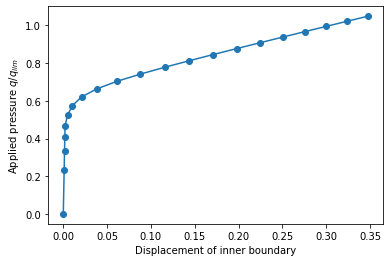

In [ ]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()